In [5]:
#Import the necessary libraries
import numpy as np
import pandas as pd
from time import time
from IPython.display import display
%matplotlib inline
# Import supplementary visualization code visuals.py
import visuals as vs

In [6]:
#Load census data & display the first row
data=pd.read_csv("census.csv")
display(data.head(2))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K


In [7]:
#total no of records 
n_records=data['age'].count()
#Records with income>=50K
n_greater_50k=data[data.income==">50K"].income.count()
#Records with income <50K
n_atmost_50k=data[data.income=="<=50K"].income.count()
#%individual whose income is more than 50K
greater_percent=float(n_greater_50k)*100/n_records
#print results
print("Total number of records:",n_records)
print("Individuals making more than $50,000:",n_greater_50k)
print("Individuals making at most $50,000:",n_atmost_50k)
print("Percentage of individuals making more than $50,000:",greater_percent)


('Total number of records:', 45222)
('Individuals making more than $50,000:', 11208)
('Individuals making at most $50,000:', 34014)
('Percentage of individuals making more than $50,000:', 24.78439697492371)


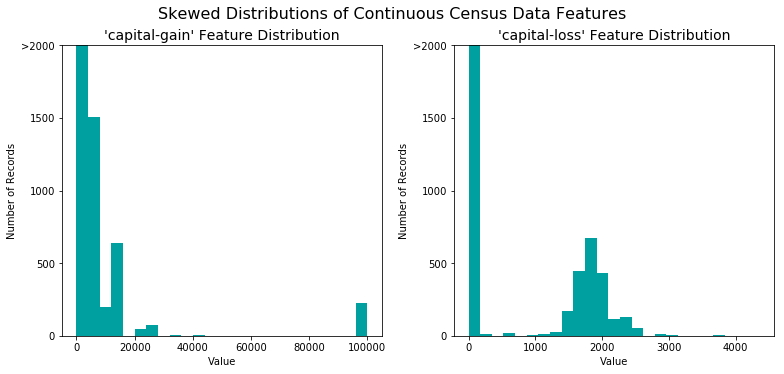

In [8]:
#split the data into features and target
income_raw = data['income']
features_raw = data.drop('income',axis=1)
#visualize the data
vs.distribution(data)

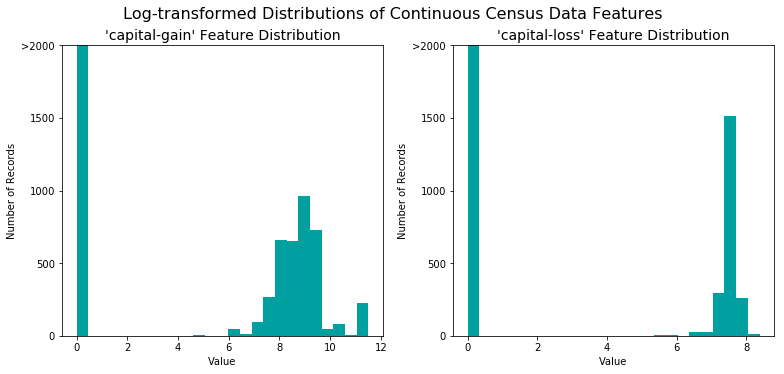

In [9]:
#Log transform skewed features
skewed = ['capital-gain','capital-loss']
features_raw[skewed]=data[skewed].apply(lambda x: np.log(x+1))
vs.distribution(features_raw,transformed=True)

Normalize the numerical features

In [10]:
from sklearn.preprocessing import MinMaxScaler
#initialize the scalar and then apply to features
scaler=MinMaxScaler()
numerical=['age','education-num','capital-gain','capital-loss','hours-per-week']
features_raw[numerical]=scaler.fit_transform(data[numerical])

#show example of recors with scaling applied
display(features_raw.head(1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


In [11]:
#one hot encode the features raw data
features = pd.get_dummies(features_raw)
#encode income_raw data to numerical values
income = income_raw.apply(lambda x: 1 if x==">50K" else 0)

#print no of features aftre encoding
encoded = list(features.columns)
print("Total features after one hot encoding:",len(encoded))

('Total features after one hot encoding:', 103)


In [12]:
#Shuffle and split data
from sklearn.cross_validation import train_test_split

X_train,X_test,y_train,y_test = train_test_split(features,income,test_size = 0.2, random_state=0)

#Show train and test no of samples
print("Training set samples:",X_train.shape[0])
print("Testing set samples:",X_test.shape[0])

C:\Users\vinit\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('Training set samples:', 36177)
('Testing set samples:', 9045)


In [13]:
#Question 1 - Naive Predictor Performace
#If we chose a model that always predicted an 
#individual made more than \$50,000, what would that 
#model's accuracy and F-score be on this dataset?

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

income_pred = income.apply(lambda x:1)
TP=sum(map(lambda x,y: 1 if x==1 and y==1 else 0,income,income_pred))
FP=sum(map(lambda x,y: 1 if x==0 and y==1 else 0, income,income_pred)) #False Pos
FN=sum(map(lambda x,y: 1 if x==1 and y==0 else 0, income,income_pred)) #False Neg

accuracy = float(TP)/(TP+FP)

recall = float(TP)/(TP+FN)

# TODO: Calculate F-score using the formula above for beta = 0.5
beta=0.5
fscore = (1+beta**2)*(accuracy*recall)/(beta**2*(accuracy+recall)+1)

print("Naive Predictor\n")
print("Accuracy:",accuracy,"F-score",fscore)

Naive Predictor

('Accuracy:', 0.2478439697492371, 'F-score', 0.236138851667383)


Implementation - Creating a Training and Predicting Pipeline

In [14]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    '''
        inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
    
     # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
    
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
            
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
Import the three supervised learning models you've discussed in the previous section.
Initialize the three models and store them in 'clf_A', 'clf_B', and 'clf_C'.
Use a 'random_state' for each model you use, if provided.
Note: Use the default settings for each model — you will tune one specific model in a later section.
Calculate the number of records equal to 1%, 10%, and 100% of the training data.
Store those values in 'samples_1', 'samples_10', and 'samples_100' respectively.
Note: Depending on which algorithms you chose, the following implementation may take some time to run!


GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.


C:\Users\vinit\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


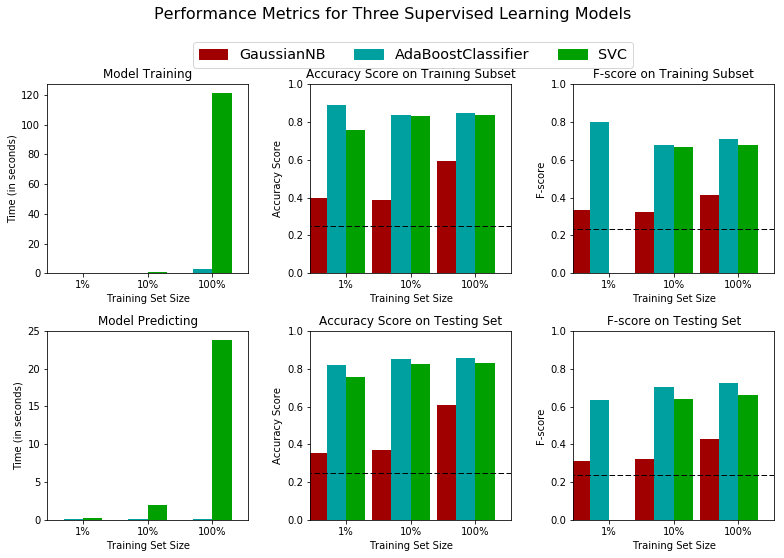

In [15]:
#todo: import 3 supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
#initialize 3 models
clf_A=GaussianNB()
clf_B=SVC(random_state=0)
clf_C=AdaBoostClassifier(random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(y_train)/100)
samples_10 = int(len(y_train)/10)
samples_100 = int(len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)        

In [16]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune
#parameters = {'n_estimators':[75,100,200]}
parameters = {'n_estimators':[75,200,500],'learning_rate':[1.0,1.5,2.0]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)
# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

C:\Users\vinit\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8677
Final F-score on the testing data: 0.7452
